# Numerical Simulation Laboratory

# Numerical exercise 7 
Eseguire una simulazione di dinamica molecolare nel sistema canonico utilizzando questa volta l'algoritmo di Metropolis; eseguire delle misure di energia poteniale per particella e pressione per studiare la loro funzione di autocorreelazione, e osservare l'andamento degli errori al variare della lunghezza dei blocchi. Implementare la funzione di correlazione a due corpi sia nel canonico che nel microcanonico e confrontare i risultati per un sistema di molecole di Argon nei due ensemble, in condizioni termodinamiche simili per le tre differenti fasi.

In questa simulazione non intregriamo le equazioni del moto per ricavare la dinamica, ma campioniamo la distribuzione delle configurazioni in base al peso di Boltzmann delle stesse, grazie all'algoritmo di Metropolis. L'interazione è rappresentata dal potenziale di Lennard-Jones, che è consistente per gas come l'Argon.

In [13]:
import math
Kb = 1.380649 * 10**-23    #cost Boltzmann in J/K
e  = 1.602176 * 10**-19    #eV/J
u  = 1.66054  * 10**-27    #Kg/amu
#Kb = Kb*e                  #cost Boltzmann in eV/K

#conversione unità ridotte in unità SI
T=120                     #K
epsilon = T * Kb          #profondità della buca in J
sigma = 0.34 * 10**-9     #lunghezza caratteristica di variazione del potenziale in metri
m = 39.9486 * u           #massa in Kg
P = epsilon/sigma**3      #pressione caratteristica in Pa
t = sigma*math.sqrt(m/epsilon)#unità di tempo in s

L=5000   #measures per block
ds_solid= sigma*0.12
ds_liquid= sigma*0.2
ds_gas= sigma*5
print('solid phase: ds=',ds_solid, 'm')
print('liquid phase: ds=',ds_liquid, 'm')
print('gas phase: ds=',ds_gas, 'm')

solid phase: ds= 4.0800000000000004e-11 m
liquid phase: ds= 6.800000000000001e-11 m
gas phase: ds= 1.7000000000000003e-09 m


Gli intervalli spaziali tra frames differenti della simulazione vanno dai $40 pm$ della fase solida agli $1.7 nm$ della fase gassosa; a differenza dell'algoritmo di Verlet, in questa simualzione non abbiamo frame temporali fissati a piacere, per questo se osservassi l'evoluzione della configurazione del sistema vedrei una dimanica meno fluida in tutti e tre i casi. Il $\delta s$ nei casi seguenti è stato tarato per cercare di soddisfare la regola empirica del $50\%$ e poter esplorare al meglio lo spazio delle configurazioni: avendo generato $5\cdot 10^5$ misure a distanza $\delta t$ ottengo
- Fase solida: $acc.rate \simeq 47\%$
- Fase liquida: $acc.rate \simeq 51\%$
- Fase gassosa: $acc.rate \simeq 63\%$

Le i valori dei parametri fisici ricavati sono stati ottenuti dopo la fase di equilibrazione, eseguita in maniera simile e con gli stessi restart dell'esercizio 4.

## Fase solida
Per il sistema nella fase solida utilizzo i seguenti valori di temperatura, densità e cut-off del potenziale riportati qui in unità ridotte di *Lennard-Jones*.
- Cut-off $r_c = 2.2$
- Densità $\rho^\star=1.1$
- Temperatura $T^\star=0.8$

### <font color=red> Lunghezza dei blocchi </font>
Dopo aver equilibrato il sistema, stampo le $5 \times 10^5$ misure a distanza $\delta t$ e osservo l'autocorrelazione delle due grandezze calcolate.

Si può osservare dai seguenti grafici che la funzione decade abbastanza rapidamente, non dovrei avere correlazione a lungo raggio tra la misure della stessa grandezza. Il fit della curva con un esponenziale sembra consistente, e posso fare una stima del tempo caratteristico di decadimento della coda:
    $$ Ac_{[x]}(\tau) \sim \exp \left( -\frac{\tau}{\tau_c} \right) \,,$$

nstep caratteristico= 3.754


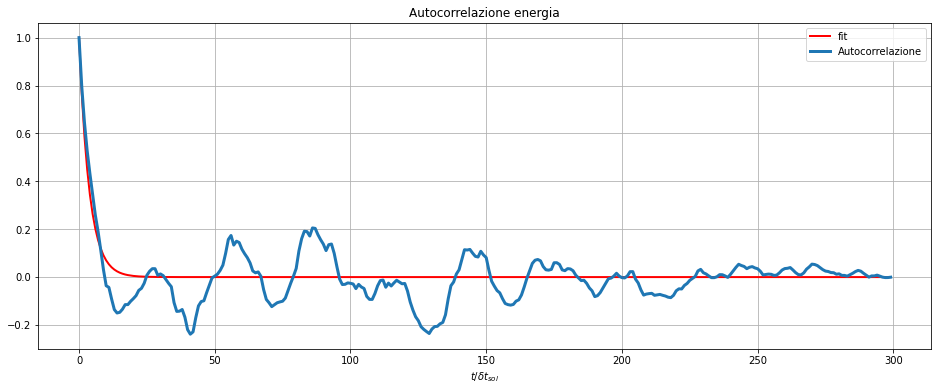

nstep caratteristico= 3.798


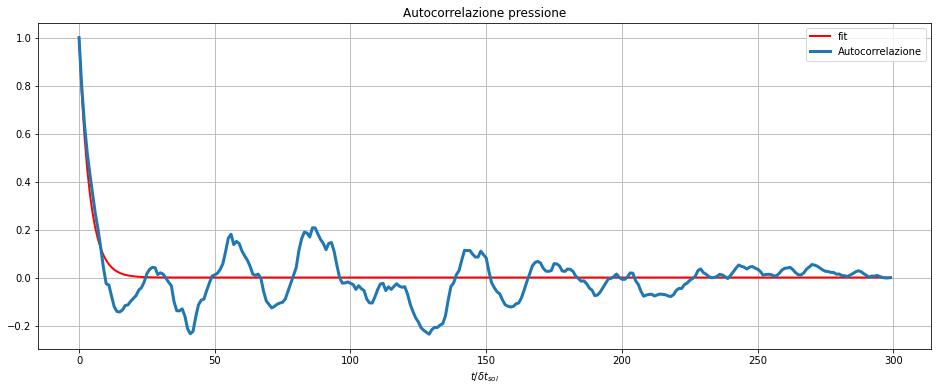

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

params=['U','P']
def exp(t, tc):
    return np.exp(-t / tc)

for par in params:
    datas = np.loadtxt('data/measures/solid/'+par+'_ac.solid', unpack=True) #energia
    t   = np.arange(len(datas))
    popt, pcov = curve_fit(exp, t, datas) #fit autocorrelazione energia
    print('nstep caratteristico=', round(*popt, 3) )
    plt.figure(figsize=(16, 6))
    plt.plot(t, exp(t, *popt), lw=2, color='red', label='fit') #fit
    plt.plot(t, datas, lw=3, label='Autocorrelazione') #autocorrelazione energia
    if par=='U': plt.title('Autocorrelazione energia')
    else: plt.title('Autocorrelazione pressione')
    plt.xlabel(r'$t/\delta t_{sol}$')
    plt.legend()
    plt.grid(True)
    plt.show()

Dal fit sembra quindi che con circa 4 step la correlazione si riduca di un fattore $e$, quindi riduco l'autocorrelazione di un ordine di grandezza ogni $4\times ln(10) \simeq 9$ passi.

Il grafico seguente mostra l'andamento delle incertezze statistiche stimate tramite il metodo delle medie a blocchi variando la lunghezza dei blocchi. Come è possibile osservare, per blocchi troppo corti le incertezze risultano sottostimate. Invece, oltre una determinata lunghezza, corrispondente a circa $1000$ step, le incertezze si stabilizzano e allungare i blocchi non modifica significativamente il loro valore.

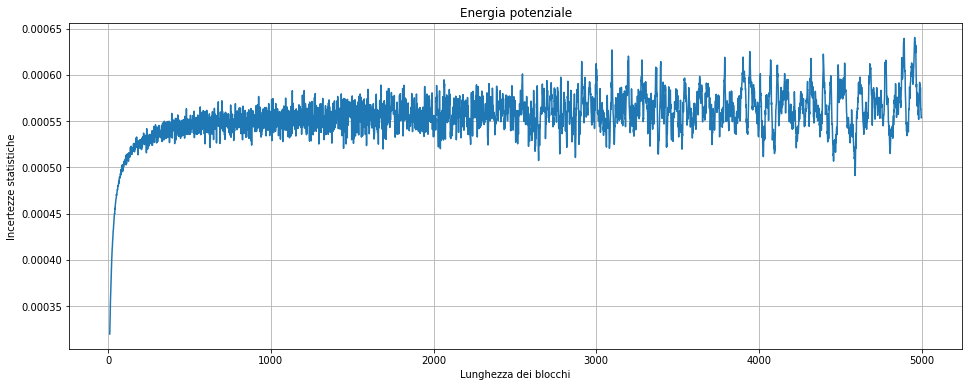

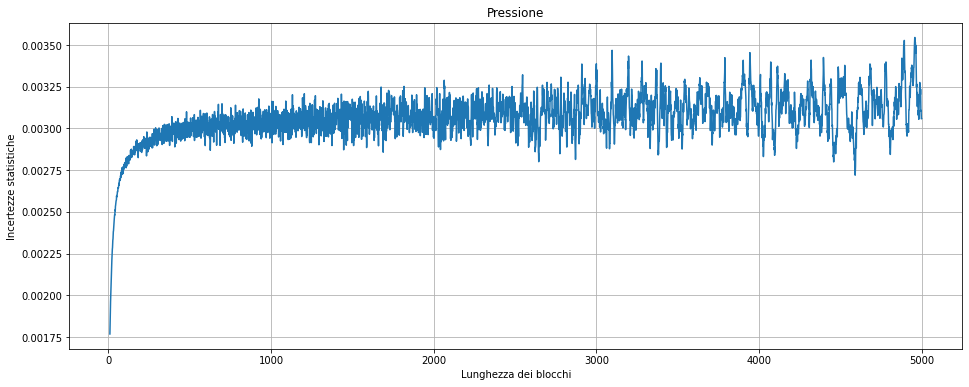

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
params=['U','P']

for par in params:
    L, error = np.loadtxt('data/measures/solid/'+par+'_blockerr.solid', unpack=True) #energia
    plt.figure(figsize=(16, 6))
    plt.plot(L, error)
    if par=='U': plt.title('Energia potenziale')
    else: plt.title('Pressione')
    plt.xlabel('Lunghezza dei blocchi')
    plt.ylabel('Incertezze statistiche')
    plt.grid(True)
    plt.show()

### <font color=red> Simulazione </font>
<img src="img/solid.gif"  width="400" style="float:right">

Dopo aver quantificato il tempo di correlazione e la dimensione minima necessaria per non sottostimare le incertezze statistiche, posso effettuare la simulazione vera e propria per stimare i valori di energia potenziale, pressione e distribuzione radiale delle particelle del sistema utilizzando il data blocking. come nel caso della dinamica molecolare, effettuo la simulazione utilizzando $100$ blocchi contenenti ciascuno $5000$ step in modo da non sottostimare le incertezze statistiche. Stiamo utilizzando condizioni termodinamiche uguali nei due casi, per cui dovrei aspettarmi un'uguaglianza dei risultati per i due ensembles.

### <font color=blue> Distribuzione radiale </font>
Determino la funzione di distribuzione radiale $g(r)$ al variare della distanza tra due particelle, sfruttando  la seguente equazione:
    $$ g(r) = \frac{1}{\rho N \Delta V} \sum_{i\neq j} \delta \left[r-\left( r_i-r_j \right)  \right] \,,$$
    
dove $\Delta V$ è il volume della shell sferica infinitesimale di spessore $dr$ centrata in $r$
    $$ \Delta V = \frac{4\pi}{3}\left[\left(r+dr\right)^3-r^3  \right] \,.$$
    
Per effettuare il calcolo è stato suddiviso l'intervallo $[0, L/2]$ in $100$ sottointervalli di ampiezza uguale $dr$ e per ciascuno di essi conto quante particelle si trovano ad una distanza  $r_{ij} \in [r, r+dr]$ costruendo così un istogramma il cui limite corrisponde alla funzione cercata. Al termine del procedimento normalizzo l'istogramma secondo l'equazione precedente e ottengo quindi un campionamento della funzione $g(r)$.

I grafici sottostanti mostrano i risultati così ottenuti per la funzione di distribuzione radiale utilizzando sia la simulazione di <em>Dinamica Molecolare</em> che la simulazione <em>Monte Carlo</em> con algoritmo di Metropolis. Si può osservare che l'accordo tra le due curve è consistente; le posizioni e in parte anche le altezze dei picchi sono ben conservate, sebbene siano stati usati algoritmi, ensembles e configurazioni equilibrate diversi! Ho notato come l'accordo tra le due curve migliora ulteriormente se parto dalle stesse configurazioni iniziali, anche se qui non è riportato.

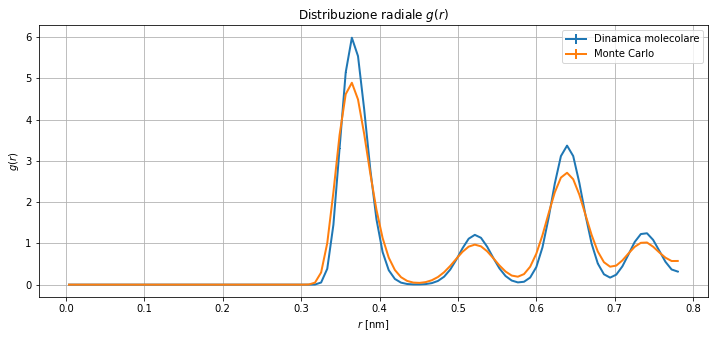

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt

rmd,gmd,errmd = np.loadtxt('../lsnex4/data/measures/solid/ave_gcor.out', unpack=True) #dinamica molecolare
rmc,gmc,errmc = np.loadtxt('data/measures/solid/output_gave.0', unpack=True) #monte carlo
#conversione unità SI
rmd *= sigma*10**9
rmc *= sigma*10**9

plt.figure(figsize=(12, 5))
plt.errorbar(rmd, gmd, yerr=errmd, label='Dinamica molecolare', lw=2) #dinamica molecolare
plt.errorbar(rmc, gmc, yerr=errmc, label='Monte Carlo', lw=2) #monte carlo
plt.title('Distribuzione radiale $g(r)$')
plt.xlabel('$r$ [nm]')
plt.ylabel('$g(r)$')
plt.grid(True)
plt.legend()
plt.show()

### <font color=blue> Energia </font>
Il grafico seguente mostra il confronto tra l'energia potenziale per particella determinata attraverso la simulazione *Monte Carlo* sfruttando l'algoritmo di Metropolis e attraverso la simulazione di *Dinamica molecolare* sfruttando l'algoritmo di Verlet: in quest'ultima simulazione, per effettuare il confronto, sono state aggiunte le **correzioni di coda** sull'energia potenziale media di ogni blocco **solo nella simulazione via Metropolis**. Per il potenziale di Lennard-Jones tali correzioni sono date dalla seguente equazione il cui risultato è espresso in unità ridotte:
    $$ \frac{\langle V_{LJ}\rangle_{tail} }{N} = \frac{8 \pi \rho}{9 r_c^9} - \frac{8 \pi \rho}{3 r_c^3} = -0.8629 \,.$$
    
I risultati così ottenuti sono qui riportati in unità SI in funzione del numero di misure effettuate durante le simulazioni. Come si può osservare, le due simulazioni hanno un convergenza qualitativamente consistente, lo scarto tra i due risultati è poco più del $5\%$, ma se osserviamo le barre di errore i due risultati hanno limiti di convergenza molto diversi; infatti distano molte deviazioni standard l'uno dell'altro. Questo è particoalrmente ben visibile qui ance per l'alto numero di misure effettuate nelle due simualzioni.

Valore finale dell'energia M(RT)^2: -0.06910397389437864 eV
Valore finale dell'energia MD     : -0.07320027658549372 eV
Scarto relativo: 5.928 %


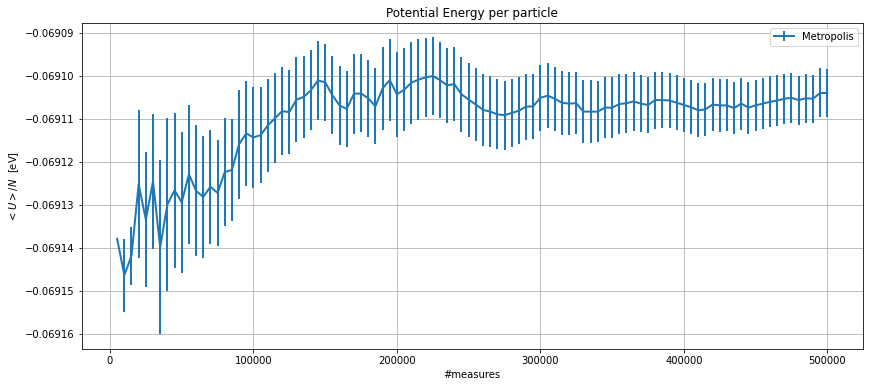

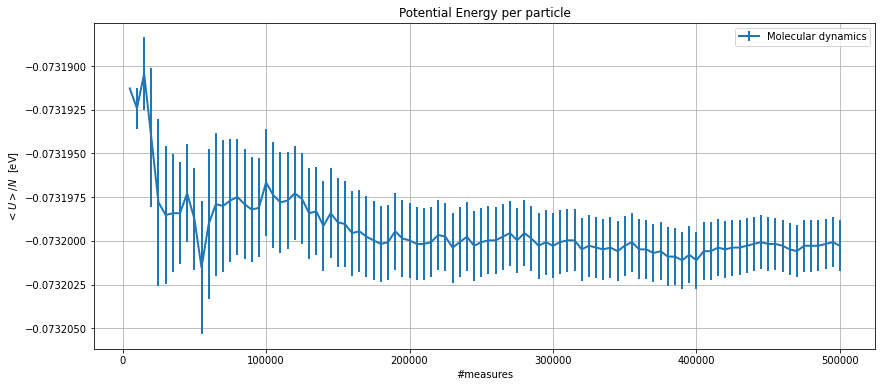

In [14]:
import math
import numpy as np
import matplotlib.pyplot as plt

file=['data/measures/solid/output_epot.0', '../lsnex4/data/measures/solid/ave_epot.out']
labels=['Metropolis', 'Molecular dynamics']
short=['M(RT)^2', 'MD     ']

for i in range(len(file)):
    n, dummy, meas, error = np.loadtxt(file[i], unpack=True)
    n*=L
    meas*=epsilon/e
    error *=epsilon/e
    print('Valore finale dell\'energia '+short[i]+':', meas[-1], 'eV')
    if i==0: vv=meas[-1]
    plt.figure(figsize=(14, 6))
    plt.title('Potential Energy per particle')
    plt.xlabel('#measures')
    plt.ylabel('$<U>/N$  [eV]')
    plt.errorbar(n, meas, error, label=labels[i], lw=2)
    plt.legend()
    plt.grid(True)
    
print('Scarto relativo:', round( abs( (vv-meas[-1])/vv )*100, 3),'%')

### <font color=blue> Pressione </font>
Il grafico seguente mostra il confronto tra la pressione determinata attraverso la simulazione *Monte Carlo* sfruttando l'algoritmo di Metropolis e attraverso la simulazione di *Dinamica molecolare* sfruttando l'algoritmo di Verlet: in quest'ultima simulazione, per effettuare il confronto, sono state aggiunte le **correzioni di coda** sul viriale medio di ogni blocco **solo nella simulazione via Metropolis**, necessario per il calcolo della pressione. Per il potenziale di Lennard-Jones tali correzioni sono date dalla seguente equazione il cui risultato è espresso in unità ridotte:
    $$ \frac{\langle w_{LJ}\rangle_{tail} }{3N} = \frac{32 \pi \rho}{9 r_c^9} - \frac{16 \pi \rho}{3 r_c^3} = -1.7207 \,.$$
I risultati così ottenuti sono qui riportati in unità SI in funzione del numero di misure effettuate durante le simulazioni. Come si può osservare i due procedimenti non sembrano convergere in maniera ottimale allo stesso risultato, loscarto relativo tra le due misure è di circa $1/5$.

Valore finale dell'energia M(RT)^2: 400107190.4600038 Pa
Valore finale dell'energia MD     : 307445774.4785262 Pa
Scarto relativo: 23.159 %


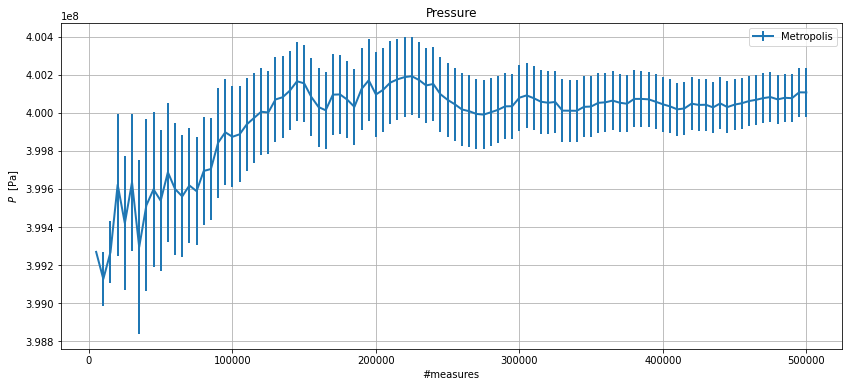

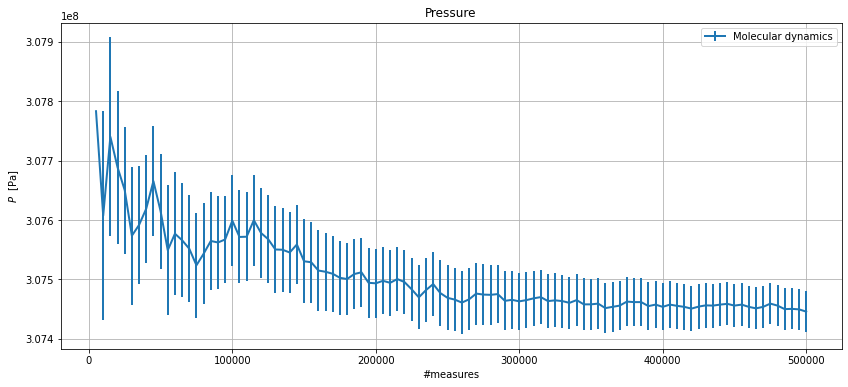

In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt

import math
import numpy as np
import matplotlib.pyplot as plt

file=['data/measures/solid/output_pres.0', '../lsnex4/data/measures/solid/ave_pres.out']
labels=['Metropolis', 'Molecular dynamics']
short=['M(RT)^2', 'MD     ']

for i in range(len(file)):
    n, dummy, meas, error = np.loadtxt(file[i], unpack=True)
    n*=L
    meas*=P
    error *=P
    print('Valore finale dell\'energia '+short[i]+':', meas[-1], 'Pa')
    if i==0: vv=meas[-1]
    plt.figure(figsize=(14, 6))
    plt.title('Pressure')
    plt.xlabel('#measures')
    plt.ylabel('$P$  [Pa]')
    plt.errorbar(n, meas, error, label=labels[i], lw=2)
    plt.legend()
    plt.grid(True)
    
print('Scarto relativo:', round( abs( (vv-meas[-1])/vv )*100, 3),'%')

## Fase liquida
Per il sistema nella fase liquida utilizzo i seguenti valori di temperatura, densità e cut-off del potenziale riportati qui in unità ridotte di *Lennard-Jones*.
- Cut-off $r_c = 2.5$
- Densità $\rho^\star=0.8$
- Temperatura $T^\star=1.1$

### <font color=red> Lunghezza dei blocchi </font>
Dopo aver equilibrato il sistema, stampo le $5 \times 10^5$ misure a distanza $\delta t$ e osservo l'autocorrelazione delle due grandezze calcolate.

Si può osservare dai seguenti grafici che la funzione decade abbastanza rapidamente, non dovrei avere correlazione a lungo raggio tra la misure della stessa grandezza. Il fit della curva con un esponenziale sembra consistente, e posso fare una stima del tempo caratteristico di decadimento della coda:
    $$ Ac_{[x]}(\tau) \sim \exp \left( -\frac{\tau}{\tau_c} \right) \,,$$

nstep caratteristico= 10.034


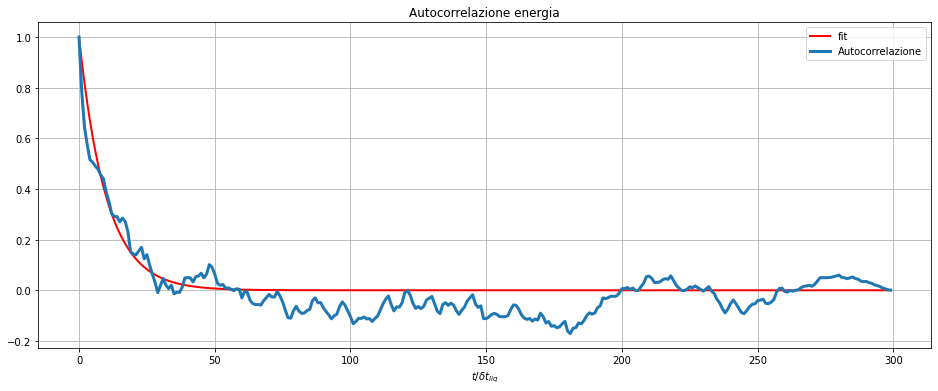

nstep caratteristico= 11.665


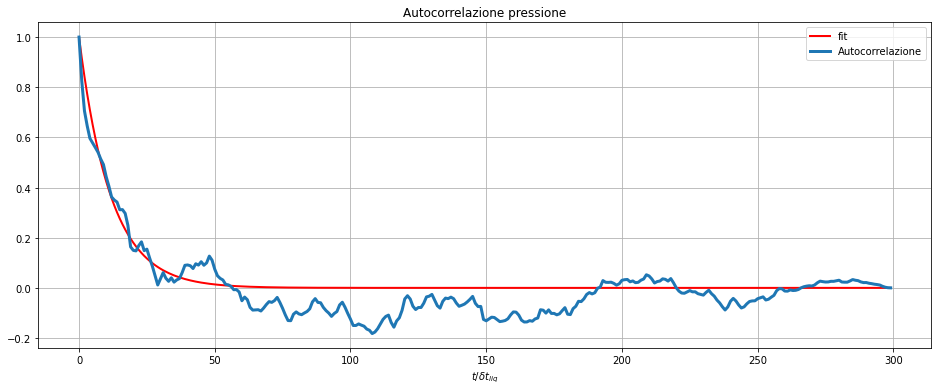

In [41]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

params=['U','P']
def exp(t, tc):
    return np.exp(-t / tc)

for par in params:
    datas = np.loadtxt('data/measures/liquid/'+par+'_ac.liquid', unpack=True) #energia
    t   = np.arange(len(datas))
    popt, pcov = curve_fit(exp, t, datas) #fit autocorrelazione energia
    print('nstep caratteristico=', round(*popt, 3) )
    plt.figure(figsize=(16, 6))
    plt.plot(t, exp(t, *popt), lw=2, color='red', label='fit') #fit
    plt.plot(t, datas, lw=3, label='Autocorrelazione') #autocorrelazione energia
    if par=='U': plt.title('Autocorrelazione energia')
    else: plt.title('Autocorrelazione pressione')
    plt.xlabel(r'$t/\delta t_{liq}$')
    plt.legend()
    plt.grid(True)
    plt.show()

Si può osservare come le misure hanno un tempo caratteristico maggiore rispetto alla fase solida, con circa $\tau _{liq}\simeq 2.5 \tau _{sol}$; per ridurre l'autocorrelazione di un ordine di grandezza devo fare $10\times ln(10) \simeq 23$ passi.

Il grafico seguente mostra l'andamento delle incertezze statistiche stimate tramite il metodo delle medie a blocchi variando la lunghezza dei blocchi. Come è possibile osservare, per blocchi troppo corti le incertezze risultano sottostimate; di nuovo, oltre una determinata lunghezza, corrispondente a circa $1000$ step, le incertezze si stabilizzano e allungare i blocchi non modifica significativamente il loro valore.

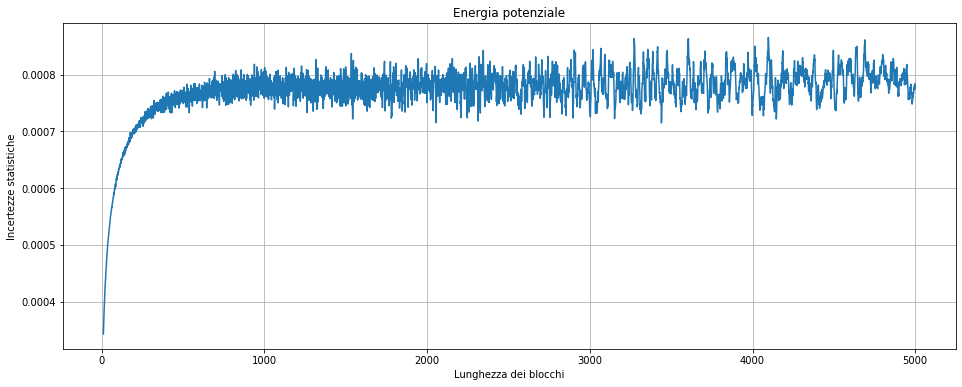

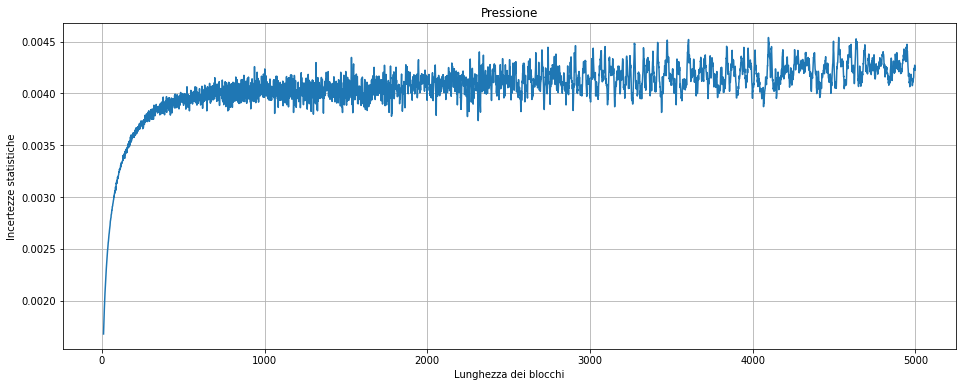

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
params=['U','P']

for par in params:
    L, error = np.loadtxt('data/measures/liquid/'+par+'_blockerr.liquid', unpack=True) #energia
    plt.figure(figsize=(16, 6))
    plt.plot(L, error)
    if par=='U': plt.title('Energia potenziale')
    else: plt.title('Pressione')
    plt.xlabel('Lunghezza dei blocchi')
    plt.ylabel('Incertezze statistiche')
    plt.grid(True)
    plt.show()

### <font color=red> Simulazione </font>
<img src="img/liquid.gif"  width="400" style="float:right">

Dopo aver quantificato il tempo di correlazione e la dimensione minima necessaria per non sottostimare le incertezze statistiche, posso effettuare la simulazione vera e propria per stimare i valori di energia potenziale, pressione e distribuzione radiale delle particelle del sistema utilizzando il data blocking. come nel caso della dinamica molecolare, effettuo la simulazione utilizzando $100$ blocchi contenenti ciascuno $5000$ step in modo da non sottostimare le incertezze statistiche. Stiamo utilizzando condizioni termodinamiche uguali nei due casi, per cui dovrei aspettarmi un'uguaglianza dei risultati per i due ensembles.

La gif qui riportata mostra le posizioni simulate delle particelle ottenute per la fase liquida: si può osservare il moto caotico ma fortemente legato che caratterizza la fase liquida del sistema.

### <font color=blue> Distribuzione radiale </font>
Come nel caso precedente determino la funzione di distribuzione radiale utilizzando sia la simulazione di <em>Dinamica Molecolare</em> che la simulazione <em>Monte Carlo</em>,  suddividendo l'intervallo $[0, L/2]$ in $100$ sottointervalli per costruire l'istogramma corrispondente a $g(r)$.

I grafici sottostanti mostrano i risultati ottenuti per la funzione $g(r)$ utilizzando sia la simulazione di <em>Dinamica Molecolare</em> che la simulazione <em>Monte Carlo</em>. La distanza tra le particelle è espressa in unità SI. Come si può osservare i risultati delle due simulazioni presentano un ottimo accordo.

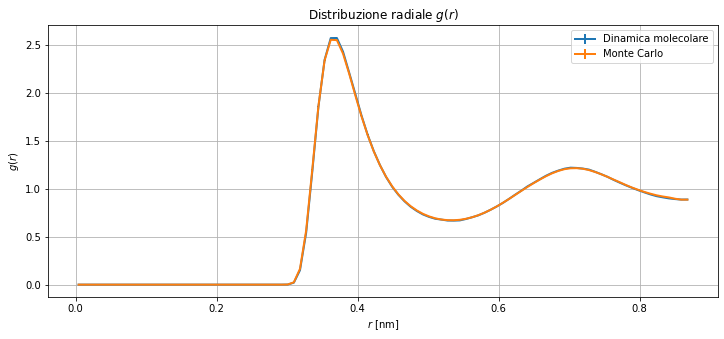

In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt

rmd,gmd,errmd = np.loadtxt('../lsnex4/data/measures/liquid/ave_gcor.out', unpack=True) #dinamica molecolare
rmc,gmc,errmc = np.loadtxt('data/measures/liquid/output_gave.0', unpack=True) #monte carlo
#conversione unità SI
rmd *= sigma*10**9
rmc *= sigma*10**9

plt.figure(figsize=(12, 5))
plt.errorbar(rmd, gmd, yerr=errmd, label='Dinamica molecolare', lw=2) #dinamica molecolare
plt.errorbar(rmc, gmc, yerr=errmc, label='Monte Carlo', lw=2) #monte carlo
plt.title('Distribuzione radiale $g(r)$')
plt.xlabel('$r$ [nm]')
plt.ylabel('$g(r)$')
plt.grid(True)
plt.legend()
plt.show()

### <font color=blue> Energia </font>
Il grafico seguente mostra il confronto tra l'energia potenziale per particella determinata attraverso la simulazione *Monte Carlo* sfruttando l'algoritmo di Metropolis e attraverso la simulazione di *Dinamica molecolare* sfruttando l'algoritmo di Verlet: in quest'ultima simulazione, per effettuare il confronto, sono state aggiunte le **correzioni di coda** sull'energia potenziale media di ogni blocco **solo nella simulazione via Metropolis**. Per il potenziale di Lennard-Jones tali correzioni sono date dalla seguente equazione il cui risultato è espresso in unità ridotte:
    $$ \frac{\langle V_{LJ}\rangle_{tail} }{N} = \frac{8 \pi \rho}{9 r_c^9} - \frac{8 \pi \rho}{3 r_c^3} = -0.4283 \,.$$
    
I risultati così ottenuti sono qui riportati in unità SI in funzione del numero di misure effettuate durante le simulazioni. Come si può osservare i due procedimenti convergono a risultati qualitativamente simili e abbastanza compatibili tra loro: lo scarto tra i due è inferiore allo $0.5\%$ anche se con questa mole di dati posso già osservare la diversa convergenza dei due risultati, che distano una decina di deviazioni standard fra loro

Valore finale dell'energia M(RT)^2: -0.052080321890553845 eV
Valore finale dell'energia MD     : -0.052311542268140325 eV
Scarto relativo: 0.444 %


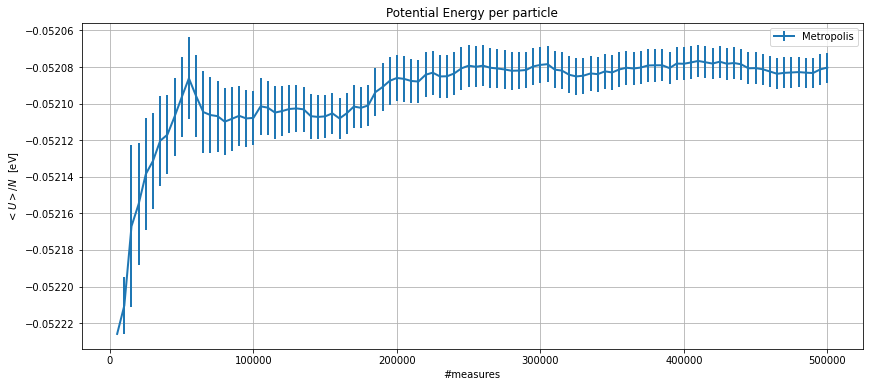

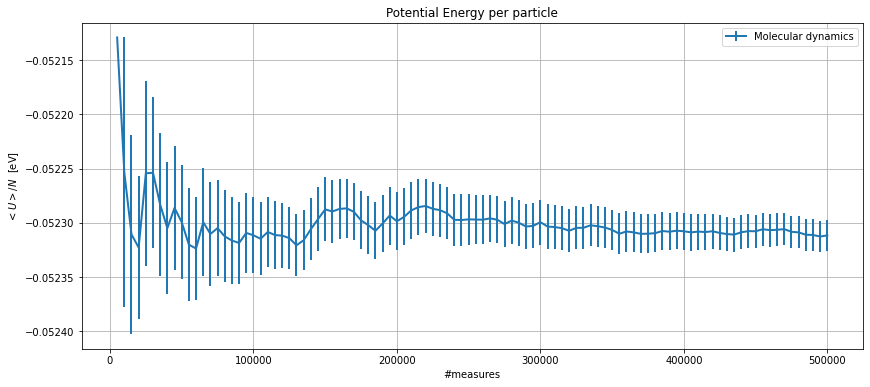

In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt

file=['data/measures/liquid/output_epot.0', '../lsnex4/data/measures/liquid/ave_epot.out']
labels=['Metropolis', 'Molecular dynamics']
short=['M(RT)^2', 'MD     ']

for i in range(len(file)):
    n, dummy, meas, error = np.loadtxt(file[i], unpack=True)
    n*=L
    meas*=epsilon/e
    error *=epsilon/e
    print('Valore finale dell\'energia '+short[i]+':', meas[-1], 'eV')
    if i==0: vv=meas[-1]
    plt.figure(figsize=(14, 6))
    plt.title('Potential Energy per particle')
    plt.xlabel('#measures')
    plt.ylabel('$<U>/N$  [eV]')
    plt.errorbar(n, meas, error, label=labels[i], lw=2)
    plt.legend()
    plt.grid(True)
    
print('Scarto relativo:', round( abs( (vv-meas[-1])/vv )*100, 3),'%')

### <font color=blue> Pressione </font>
Il grafico seguente mostra il confronto tra la pressione determinata attraverso la simulazione *Monte Carlo* sfruttando l'algoritmo di Metropolis e attraverso la simulazione di *Dinamica molecolare* sfruttando l'algoritmo di Verlet. Per effettuare tale confronto, in quest'ultima simulazione, sono state aggiunte le **correzioni di coda** sul viriale medio di ogni blocco **solo nella simulazione via Metropolis**, necessario per il calcolo della pressione. Per il potenziale di Lennard-Jones tali correzioni sono date dalla seguente equazione il cui risultato è espresso in unità ridotte:
    $$ \frac{\langle w_{LJ}\rangle_{tail} }{3N} = \frac{32 \pi \rho}{9 r_c^9} - \frac{16 \pi \rho}{3 r_c^3} = -0.8555 \,.$$
I risultati così ottenuti sono qui riportati in unità SI in funzione del numero di misure effettuate durante le simulazioni. Come si può osservare i due procedimenti convergono a risultati qualitativamente simili, con uno scarto del $5\%$ circa tra i due risultati, che tra loro distano circa 3 deviazioni standard

Valore finale dell'energia M(RT)^2: 87603064.26155093 eV
Valore finale dell'energia MD     : 83692958.38204758 eV
Scarto relativo: 4.463 %


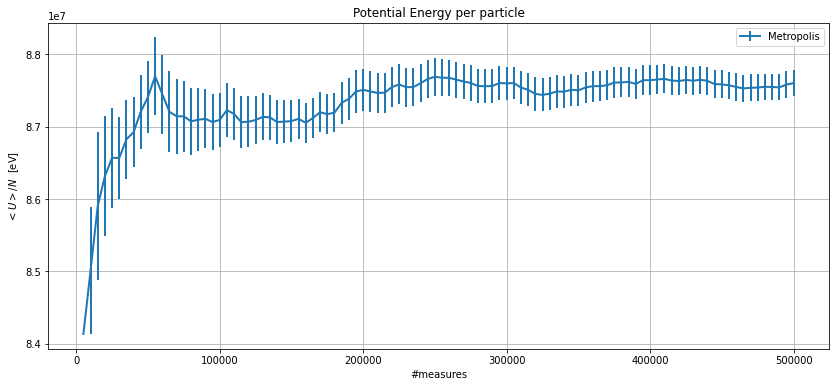

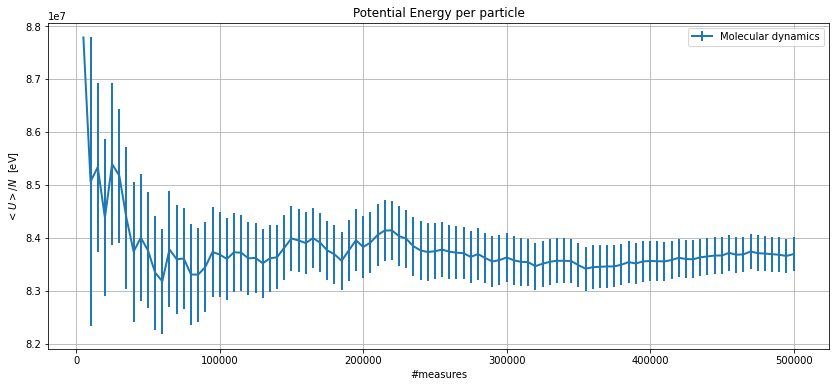

In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt

file=['data/measures/liquid/output_pres.0', '../lsnex4/data/measures/liquid/ave_pres.out']
labels=['Metropolis', 'Molecular dynamics']
short=['M(RT)^2', 'MD     ']

for i in range(len(file)):
    n, dummy, meas, error = np.loadtxt(file[i], unpack=True)
    n*=L
    meas*=P
    error *=P
    print('Valore finale dell\'energia '+short[i]+':', meas[-1], 'eV')
    if i==0: vv=meas[-1]
    plt.figure(figsize=(14, 6))
    plt.title('Potential Energy per particle')
    plt.xlabel('#measures')
    plt.ylabel('$<U>/N$  [eV]')
    plt.errorbar(n, meas, error, label=labels[i], lw=2)
    plt.legend()
    plt.grid(True)
    
print('Scarto relativo:', round( abs( (vv-meas[-1])/vv )*100, 3),'%')

## Fase gassosa
Per il sistema nella fase gassosa utilizzo i seguenti valori di temperatura, densità e cut-off del potenziale riportati qui in unità ridotte di *Lennard-Jones*.
- Cut-off $r_c = 5.0$
- Densità $\rho^\star=0.05$
- Temperatura $T^\star=1.2$

### <font color=red> Lunghezza dei blocchi </font>
Dopo aver equilibrato il sistema, stampo le $5 \times 10^5$ misure a distanza $\delta t$ e osservo l'autocorrelazione delle due grandezze calcolate.

Si può osservare dai seguenti grafici che la funzione decade abbastanza rapidamente, non dovrei avere correlazione a lungo raggio tra la misure della stessa grandezza. Il fit della curva con un esponenziale sembra consistente, e posso fare una stima del tempo caratteristico di decadimento della coda:
    $$ Ac_{[x]}(\tau) \sim \exp \left( -\frac{\tau}{\tau_c} \right) \,,$$

Si noti come i valori del tempo caratteristico ottenuti dai fit sono sensibilmente inferiori rispetto alle due fasi solida e liquida.

nstep caratteristico= 2.797


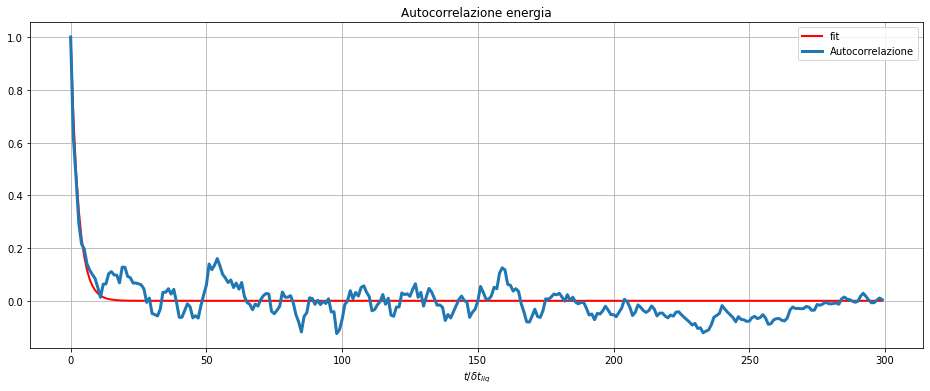

nstep caratteristico= 0.561


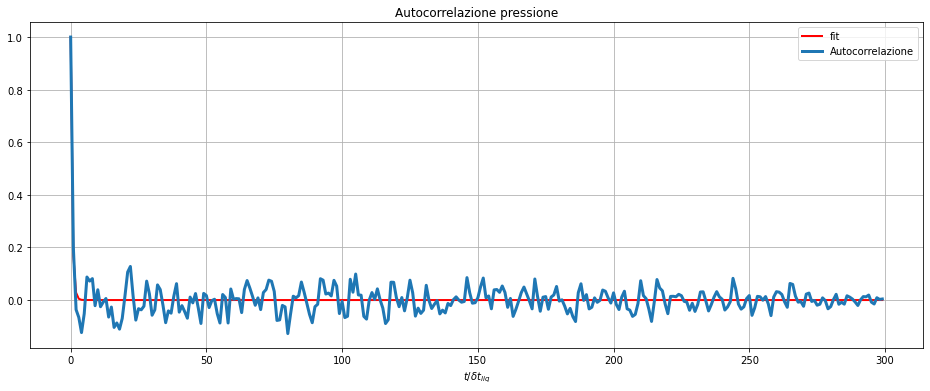

In [42]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

params=['U','P']
def exp(t, tc):
    return np.exp(-t / tc)

for par in params:
    datas = np.loadtxt('data/measures/gas/'+par+'_ac.gas', unpack=True) #energia
    t   = np.arange(len(datas))
    popt, pcov = curve_fit(exp, t, datas) #fit autocorrelazione energia
    print('nstep caratteristico=', round(*popt, 3) )
    plt.figure(figsize=(16, 6))
    plt.plot(t, exp(t, *popt), lw=2, color='red', label='fit') #fit
    plt.plot(t, datas, lw=3, label='Autocorrelazione') #autocorrelazione energia
    if par=='U': plt.title('Autocorrelazione energia')
    else: plt.title('Autocorrelazione pressione')
    plt.xlabel(r'$t/\delta t_{liq}$')
    plt.legend()
    plt.grid(True)
    plt.show()

Già dopo uno o due passi l'autocorrelazione viene ridotta di fattore $e$.

Il grafico seguente mostra l'andamento delle incertezze statistiche stimate tramite il metodo delle medie a blocchi variando la lunghezza dei blocchi. L'incertezza ha un andamento peculiare: sembra abbassarsi in media dopo un massimo vicino a $L=200$ e le sue fluttuazioni continuano ad aumentare; almeno in questo range non sembrano convergere ad un valore fissato!

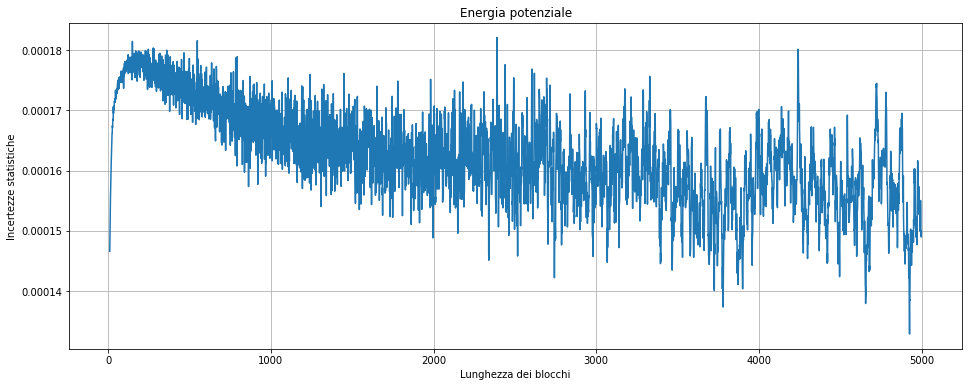

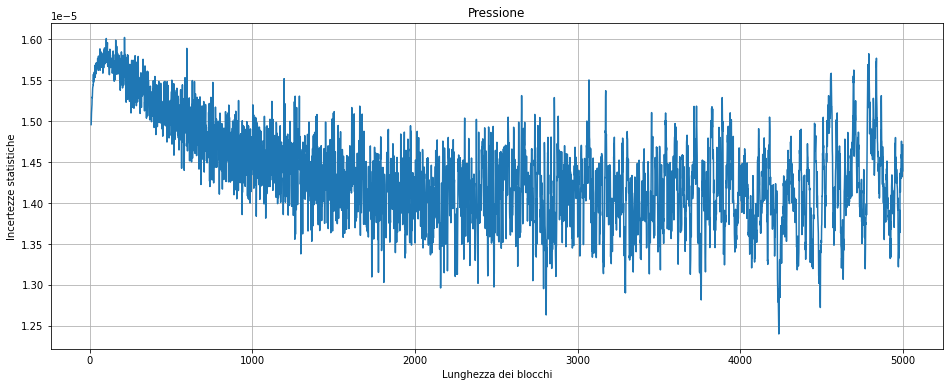

In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
params=['U','P']

for par in params:
    L, error = np.loadtxt('data/measures/gas/'+par+'_blockerr.gas', unpack=True) #energia
    plt.figure(figsize=(16, 6))
    plt.plot(L, error)
    if par=='U': plt.title('Energia potenziale')
    else: plt.title('Pressione')
    plt.xlabel('Lunghezza dei blocchi')
    plt.ylabel('Incertezze statistiche')
    plt.grid(True)
    plt.show()

### <font color=red> Simulazione </font>
<img src="img/gas.gif"  width="400" style="float:right">

Dopo aver quantificato il tempo di correlazione e la dimensione minima necessaria per non sottostimare le incertezze statistiche, posso effettuare la simulazione vera e propria per stimare i valori di energia potenziale, pressione e distribuzione radiale delle particelle del sistema utilizzando il data blocking. come nel caso della dinamica molecolare, effettuo la simulazione utilizzando $100$ blocchi contenenti ciascuno $5000$ step in modo da non sottostimare le incertezze statistiche. Stiamo utilizzando condizioni termodinamiche uguali nei due casi, per cui dovrei aspettarmi un'uguaglianza dei risultati per i due ensembles.

La gif qui riportata mostra le posizioni simulate delle particelle ottenute per la fase gassosa: si può osservare il moto caotico e poco legato che caratterizza la fase gassosa del sistema. A differenza dei casi precedenti è evidente una significativa diminuzione di densità.

### <font color=blue> Distribuzione radiale </font>

Come nel caso precedente determino la funzione di distribuzione radiale utilizzando sia la simulazione di <em>Dinamica Molecolare</em> che la simulazione <em>Monte Carlo</em>,  suddividendo l'intervallo $[0, L/2]$ in $100$ sottointervalli per costruire l'istogramma corrispondente a $g(r)$.

I grafici sottostanti mostrano i risultati ottenuti per la funzione $g(r)$ utilizzando sia la simulazione di <em>Dinamica Molecolare</em> che la simulazione <em>Monte Carlo</em>. La distanza tra le particelle è espressa in unità SI. Le due curve hanno posizione dei picchi consistenti fra loro, tuttavia le altezze presentano differenze evidenti, il sistema simulato con algoritmo di Metropolis sembra meno strutturato: questo potrebbe presagire risultati abbastanza differenti per misure di pressione e energia potenziale con i due metodi

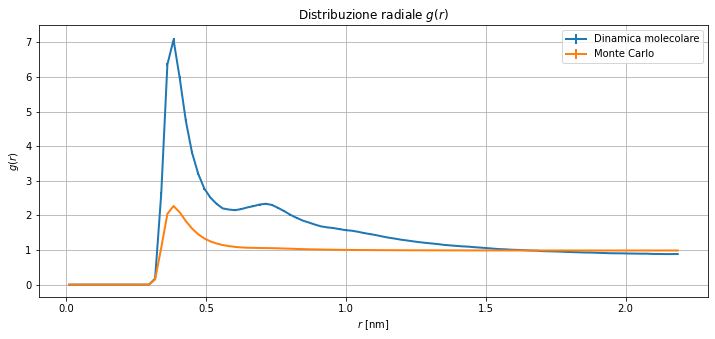

In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt

rmd,gmd,errmd = np.loadtxt('../lsnex4/data/measures/gas/ave_gcor.out', unpack=True) #dinamica molecolare
rmc,gmc,errmc = np.loadtxt('data/measures/gas/output_gave.0', unpack=True) #monte carlo
#conversione unità SI
rmd *= sigma*10**9
rmc *= sigma*10**9

plt.figure(figsize=(12, 5))
plt.errorbar(rmd, gmd, yerr=errmd, label='Dinamica molecolare', lw=2) #dinamica molecolare
plt.errorbar(rmc, gmc, yerr=errmc, label='Monte Carlo', lw=2) #monte carlo
plt.title('Distribuzione radiale $g(r)$')
plt.xlabel('$r$ [nm]')
plt.ylabel('$g(r)$')
plt.grid(True)
plt.legend()
plt.show()

### <font color=blue> Energia </font>
Il grafico seguente mostra il confronto tra l'energia potenziale per particella determinata attraverso la simulazione *Monte Carlo* sfruttando l'algoritmo di Metropolis e attraverso la simulazione di *Dinamica molecolare* sfruttando l'algoritmo di Verlet: in quest'ultima simulazione, per effettuare il confronto, sono state aggiunte le **correzioni di coda** sull'energia potenziale media di ogni blocco **solo nella simulazione via Metropolis**. Per il potenziale di Lennard-Jones tali correzioni sono date dalla seguente equazione il cui risultato è espresso in unità ridotte:
    $$ \frac{\langle V_{LJ}\rangle_{tail} }{N} = \frac{8 \pi \rho}{9 r_c^9} - \frac{8 \pi \rho}{3 r_c^3} = -0.0034 \,.$$
    
I risultati così ottenuti sono qui riportati in unità SI in funzione del numero di misure effettuate durante le simulazioni. Si osserva che i due risultati differiscono in maniera notevole: in questa fase l'evoluzione del sistema deve differire in qualche maniera per le due diverse simulazioni.

Valore finale dell'energia M(RT)^2: -0.00425315200628645 eV
Valore finale dell'energia MD     : -0.010594670744911919 eV
Scarto relativo: 59.856 %


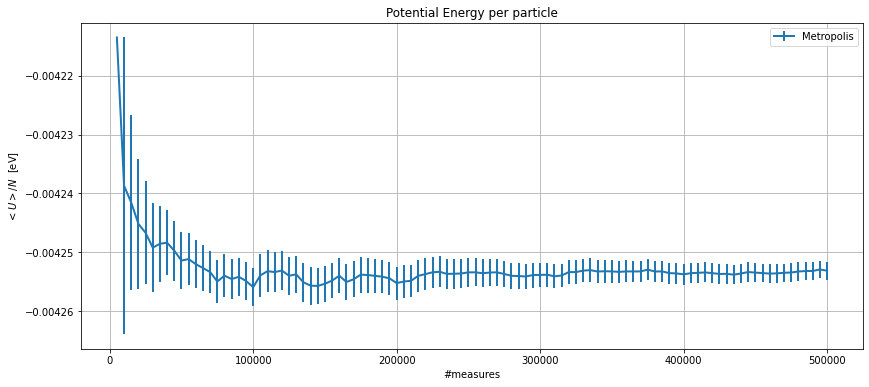

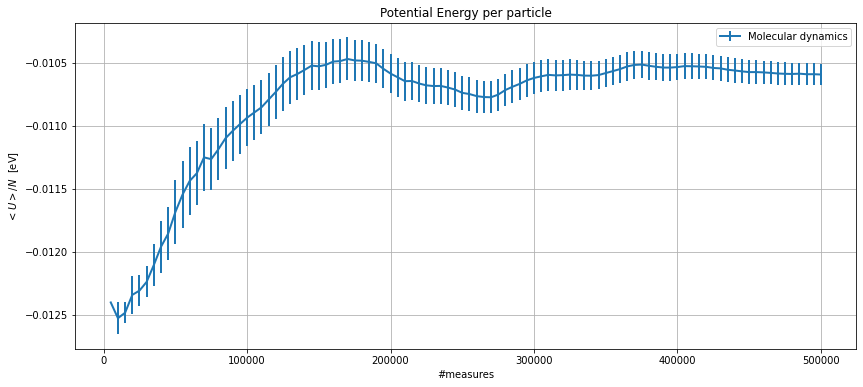

In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt

file=['data/measures/gas/output_epot.0', '../lsnex4/data/measures/gas/ave_epot.out']
labels=['Metropolis', 'Molecular dynamics']
short=['M(RT)^2', 'MD     ']

for i in range(len(file)):
    n, dummy, meas, error = np.loadtxt(file[i], unpack=True)
    n*=L
    meas*=epsilon/e
    error *=epsilon/e
    print('Valore finale dell\'energia '+short[i]+':', meas[-1], 'eV')
    if i==0: vv=meas[-1]
    plt.figure(figsize=(14, 6))
    plt.title('Potential Energy per particle')
    plt.xlabel('#measures')
    plt.ylabel('$<U>/N$  [eV]')
    plt.errorbar(n, meas, error, label=labels[i], lw=2)
    plt.legend()
    plt.grid(True)
    
print('Scarto relativo:', round( abs( (vv-meas[-1])/meas[-1] )*100, 3),'%')

### <font color=blue> Pressione </font>
Il grafico seguente mostra il confronto tra la pressione determinata attraverso la simulazione *Monte Carlo* sfruttando l'algoritmo di Metropolis e attraverso la simulazione di *Dinamica molecolare* sfruttando l'algoritmo di Verlet: in quest'ultima simulazione, per effettuare il confronto,  sono state aggiunte le **correzioni di coda** sul viriale medio di ogni blocco **solo nella simulazione via Metropolis**, necessario per il calcolo della pressione. Per il potenziale di Lennard-Jones tali correzioni sono date dalla seguente equazione il cui risultato è espresso in unità ridotte:
    $$ \frac{\langle w_{LJ}\rangle_{tail} }{3N} = \frac{32 \pi \rho}{9 r_c^9} - \frac{16 \pi \rho}{3 r_c^3} = -0.0067 \,.$$
    
I risultati così ottenuti sono qui riportati in unità SI in funzione del numero di misure effettuate durante le simulazioni. Lo scarto tra i due risultati è più piccolo rispetto al caso dell'energia ma ancora importante

Valore finale dell'energia M(RT)^2: 2080441.0483024616 eV
Valore finale dell'energia MD     : 1663270.351373905 eV
Scarto relativo: 20.052 %


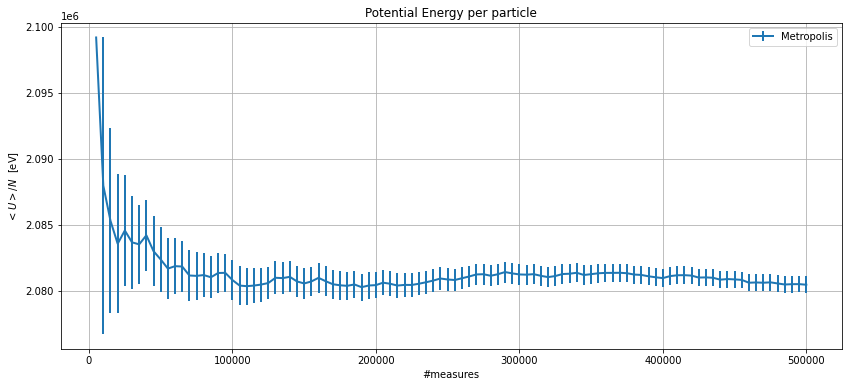

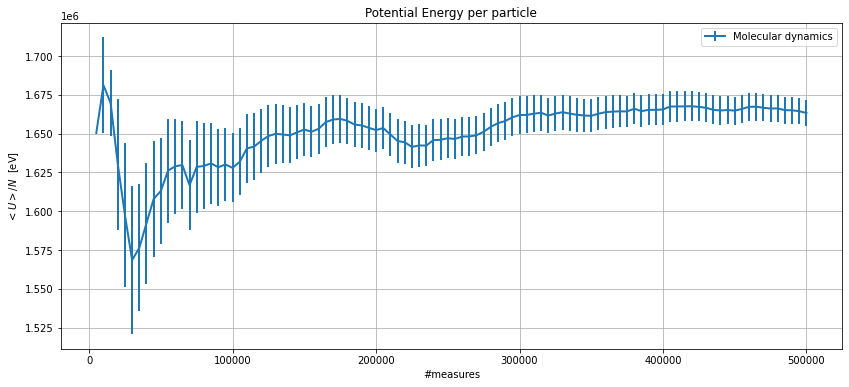

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt

file=['data/measures/gas/output_pres.0', '../lsnex4/data/measures/gas/ave_pres.out']
labels=['Metropolis', 'Molecular dynamics']
short=['M(RT)^2', 'MD     ']

for i in range(len(file)):
    n, dummy, meas, error = np.loadtxt(file[i], unpack=True)
    n*=L
    meas*=P
    error *=P
    print('Valore finale dell\'energia '+short[i]+':', meas[-1], 'eV')
    if i==0: vv=meas[-1]
    plt.figure(figsize=(14, 6))
    plt.title('Potential Energy per particle')
    plt.xlabel('#measures')
    plt.ylabel('$<U>/N$  [eV]')
    plt.errorbar(n, meas, error, label=labels[i], lw=2)
    plt.legend()
    plt.grid(True)
    
print('Scarto relativo:', round( abs( (vv-meas[-1])/vv )*100, 3),'%')